# CS549 Machine Learning - Irfan Khan 
# Assignment 5: Clustering algorithms on image data

Updated from assignment designed by Yang Xu, Ex-Assistant Professor of Computer Science, San Diego State University

**Total points: 14**

In this assignment, you will practice implementing K-means clustering, and then apply it on a subset of sign language dataset. In particular, we use the first three signs contained in the first 491 rows of X_train.npy. Later on in Task 6, you will practice DBScan.

The `PCA` module provided by `sklearn` package will be used for pre-clustering analysis and post-clustering visualization. 
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

np.random.seed(1)
%matplotlib inline

## Load data

Load data and preprocess - basically create a 2D array with 491 rows corresponding to the images for first three signs. The columns would contain the image representation. 64 x 64 pixels per image = 4096 dimensions

In [5]:
X_all = np.load(open('X_train.npy', 'rb'))


X = X_all[:491,:]

print(X_all.shape)

X = X.reshape(491, -1)

print('Shape of X:', X.shape)

(1644, 64, 64, 1)
Shape of X: (491, 4096)


## Expected output 

(1644, 64, 64, 1)<br>
Shape of X: (491, 4096)

---
## Analysis

First, we reduce and dimension of the original data to 2, and plot it. The goal of this step is to have some clue of what $k$ values to use, i.e., the number of clusters.

We know that image data of 3 classes are selected, but we use them as if they are unlabelled. Judging from the 2-D plot, there are quite amount of outliers in data, and choosing $k=3$ may well group those outliers into a cluster, instead of grouping into the correct classes. For this we will find out at the last step.

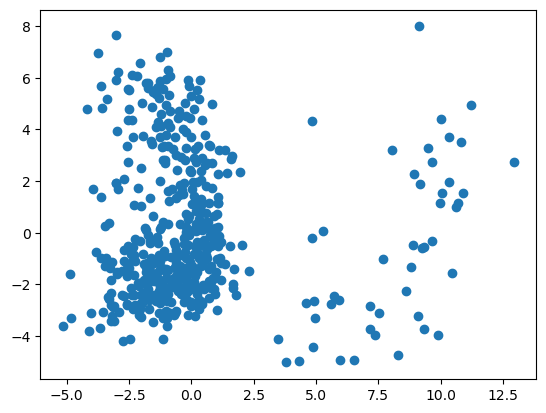

In [6]:
pca = PCA(n_components=2)
pca.fit(X)
X_proj = pca.transform(X)

# Plot
fig = plt.figure()
plt.scatter(X_proj[:,0], X_proj[:,1])
plt.show()

## Expected Output

<img src="A6image2.png">

---
## Task 1. Initialize centroids
**1 points**

The first step of k-means is to randomly initialize a set of centroids. To accomplish this, we simply select $k$ out of the $m$ data points randomly.

**Instructions:**
- Data are stored in rows in `X`. We draw `k` random rows out of it by calling `numpy.random.choice()`. Notice that use the argument `replace=False` is important. Otherwise, it is possible to sample repeated points.
- The returned `centroids` are in shape (k, n).

In [ ]:
# Initialize centroids
def init_centroids(X, k):
    """
    Args:
    X -- data, shape (m,n)
    k -- number of clusters
    
    Return:
    centroids -- k randomly picked data points as initial centroids, shape (k,n)
    """
    assert(k > 1)
    np.random.seed(1)
    
    ### START YOUR CODE ###

    idx = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[idx, :]
    ### END YOUR CODE ###
    
    return centroids

In [8]:
# Evaluate Task 1
np.random.seed(1)


X_tmp = np.random.randn(10,4)
c = init_centroids(X_tmp, k=3)

print ('X_tmp', X_tmp)

print('Shape of centroids:', c.shape)
print('centroids:', c)



X_tmp [[ 1.62434536 -0.61175641 -0.52817175 -1.07296862]
 [ 0.86540763 -2.3015387   1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038  1.46210794 -2.06014071]
 [-0.3224172  -0.38405435  1.13376944 -1.09989127]
 [-0.17242821 -0.87785842  0.04221375  0.58281521]
 [-1.10061918  1.14472371  0.90159072  0.50249434]
 [ 0.90085595 -0.68372786 -0.12289023 -0.93576943]
 [-0.26788808  0.53035547 -0.69166075 -0.39675353]
 [-0.6871727  -0.84520564 -0.67124613 -0.0126646 ]
 [-1.11731035  0.2344157   1.65980218  0.74204416]]
Shape of centroids: (3, 4)
centroids: [[ 0.3190391  -0.24937038  1.46210794 -2.06014071]
 [-1.11731035  0.2344157   1.65980218  0.74204416]
 [ 0.90085595 -0.68372786 -0.12289023 -0.93576943]]


# Expected output

X_tmp [[ 1.62434536 -0.61175641 -0.52817175 -1.07296862]<br>
 [ 0.86540763 -2.3015387   1.74481176 -0.7612069 ]<br>
 [ 0.3190391  -0.24937038  1.46210794 -2.06014071]<br>
 [-0.3224172  -0.38405435  1.13376944 -1.09989127]<br>
 [-0.17242821 -0.87785842  0.04221375  0.58281521]<br>
 [-1.10061918  1.14472371  0.90159072  0.50249434]<br>
 [ 0.90085595 -0.68372786 -0.12289023 -0.93576943]<br>
 [-0.26788808  0.53035547 -0.69166075 -0.39675353]<br>
 [-0.6871727  -0.84520564 -0.67124613 -0.0126646 ]<br>
 [-1.11731035  0.2344157   1.65980218  0.74204416]]<br>
Shape of centroids: (3, 4)<br>
centroids: [[ 0.3190391  -0.24937038  1.46210794 -2.06014071]<br>
 [-1.11731035  0.2344157   1.65980218  0.74204416]<br>
 [ 0.90085595 -0.68372786 -0.12289023 -0.93576943]]<br>


***

## Task 2. Compute distance between data points and centroids
**3 points**

Next, we need to compute the distances between data points and centroids. More concretely, for each data point `X[i,:]`, we need to compute its distance from the $k$ centroids, i.e., `centroids[j,:]` ($j=1,2,\dots,k$). We will store the computed distances in a $k\times m$ array, in which the element at position $(i,j)$ is the distance between `centroids[i,:]` and `X[j,:]`. We use Euclidean distance.

There are multiple ways of implementing this computation. For example:

You create an empty array distances of shape (k, m).
Then you use a for loop, for j in range(k):, and in each step, you compute S = X - centroids[j,:] followed by S**2, numpy.sum(), and numpy.sqrt() to get the Euclidean distance, which is stored in a (1,m) array d. Then you copy d back to the jth row of distances.



In [11]:
# Compute distances
def compute_distances(X, centroids):
    """
    Args:
    X -- data, shape (m,n)
    centroids -- shape (k,n)
    
    Return:
    distances -- shape (k,m)
    """
    ### START YOUR CODE ###
    
    k = centroids.shape[0]
    m = X.shape[0]
    distances = np.zeros((k, m))
    
    for i in range(k):
        diff = X - centroids[i]  
        dist_i = np.sqrt(np.sum(diff**2, axis=1))  
        distances[i, :] = dist_i
    ### END YOUR CODE ###
    
    
    return distances

In [12]:
# Evaluate Task 2
np.random.seed(1)
X_tmp = np.random.randn(5,4)
c = init_centroids(X_tmp, k=2)


dists = compute_distances(X_tmp, c)
print('Distances:', dists)

Distances: [[2.60208956 2.50540693 0.         1.208094   3.10448915]
 [2.94872855 0.         2.50540693 2.36130342 2.79449534]]


### Expected output

Distances: [[2.60208956 2.50540693 0.         1.208094   3.10448915]<br>
 [2.94872855 0.         2.50540693 2.36130342 2.79449534]]<br>


***

## Task 3. Find the closest centroid for each data point
**2 point**

Given the distances computed, we can find the closest centroid for each data point. We store this information in a $m\times 1$ array, and each element is the index of the closest centroid, i.e., an integer ranging from $0$ to $k-1$.

**Instructions:**
- You can apply `numpy.argmin()` on the `distances` computed in previous step as input, and a proper `axis` argument.

In [13]:
# Find the closest centroid for each data point
def closest_centroid(distances):
    """
    Args:
    distances -- numpy array of shape (k,m), output of compute_distances()
    
    Return:
    indices -- numpy array of shape (1,m)
    """
    ### START YOUR CODE ###
    indices = np.argmin(distances, axis=0)
    ### END YOUR CODE ###
    
    return indices

In [14]:
# Evaluate Task 3
np.random.seed(1)
X_tmp = np.random.randn(5,4)
c = init_centroids(X_tmp, k=2)

dists = compute_distances(X_tmp, c)
closest_indices = closest_centroid(dists)

print('Indices of the closest centroids:', closest_indices)

Indices of the closest centroids: [0 1 0 0 1]


### Expected output

Indices of the closest centroids: [0 1 0 0 1]<br>



## Task 4. Update centroids
**2 points**

Given the indices of closest centroid for each data point, you need to update the centroids by computing the average positions of the data points belonging to each cluster ($1,2,\dots,k$).

**Instructions:**
- Because `closest_indices` (output of `closes_centroid()`) is of shape (1,m), you can access the data points whose closest centroid is `j` by using the slice `X[closest_indices==j,:]`.
- Pay attention to the dimension of `new_centroids` computed, and it needs to be the same as `centroids`.

In [ ]:
# Update centroids
def update_centroids(X, closest_indices, centroids):
    """
    Args:
    X -- data, shape (m,n)
    closest_indices -- output of closest_centroid()
    centroids -- old centroids positions
    
    Return:
    new_centroids -- new centroids positions, shape (k,n)
    """
    ### START YOUR CODE ### 
    
    k = centroids.shape[0]
    new_centroids = np.zeros_like(centroids)
    
    for j in range(k):
        points_in_cluster = X[closest_indices == j]
        
        if len(points_in_cluster) > 0:
            new_centroids[j] = np.mean(points_in_cluster, axis=0)
        else:
            new_centroids[j] = centroids[j]

    ### END YOUR CODE ###
    
    assert(centroids.shape == new_centroids.shape)
    
    return new_centroids

In [17]:
# Evaluate Task 4
np.random.seed(1)
X_tmp = np.random.randn(4,5)
c = init_centroids(X_tmp, k=2)

dists = compute_distances(X_tmp, c)
closest_indices = closest_centroid(dists)
new_c = update_centroids(X_tmp, closest_indices, c)

print('New centroids:', new_c)

New centroids: [[-1.70071498  0.78619178 -0.81953266  0.18062642  0.16672242]
 [ 1.54322665 -1.33594856 -0.42529448 -0.72851149  0.99958854]]


### Expected output

New centroids: [[-1.70071498  0.78619178 -0.81953266  0.18062642  0.16672242]<br>
 [ 1.54322665 -1.33594856 -0.42529448 -0.72851149  0.99958854]]


***

## Task 5. Integrated model
**2 points**

Finally, we combine all the previous steps into one model. We repeatedly find the closest centroid for each data points, and then update the centroids, until the centroids no longer change. The final stable `closest_indices` is then the clustering result.

In [18]:
# K-means
def kmeans(X, k):
    """
    Args:
    X -- data, shape (m,n)
    k -- number of clusters
    
    Return:
    closest_indices -- final assignment of clusters to each data point, shape (1, m)
    centroids -- final positions of centroids
    """
    
    centroids = init_centroids(X, k)
    
    
    
    old_centroids = None
    while not np.array_equal(old_centroids, centroids):
        
        
        # Backup centroids
        old_centroids = np.copy(centroids)
        
        ### START YOUR CODE ###
        # Compute distances
        distances = compute_distances(X, centroids)
    
        # Find closest centroid
        closest_indices = closest_centroid(distances)
    
        
        # Update centroids
        centroids = update_centroids(X, closest_indices, centroids)
        
        ### END YOUR CODE ###
    
    return closest_indices, centroids

In [19]:
# Evaluate Task 5
closest_indices, centroids = kmeans(X, 3)

print('closest_indices[:10]', closest_indices[:10])
print('closest_indices[70:80]', closest_indices[70:80])
print('closest_indices[140:150]', closest_indices[140:150])
print('closest_indices[210:220]', closest_indices[210:220])

closest_indices[:10] [1 1 0 0 1 1 1 1 1 0]
closest_indices[70:80] [1 1 1 1 1 1 1 1 1 1]
closest_indices[140:150] [1 1 1 1 1 1 1 1 1 0]
closest_indices[210:220] [2 1 1 1 2 2 2 2 2 2]


### Expected output

closest_indices[:10] [1 1 0 0 1 1 1 1 1 0]<br>
closest_indices[70:80] [1 1 1 1 1 1 1 1 1 1]<br>
closest_indices[140:150] [1 1 1 1 1 1 1 1 1 0]<br>
closest_indices[210:220] [2 1 1 1 2 2 2 2 2 2]

***

## Visualize clustering result using PCA from sklearn library (ungraded) 


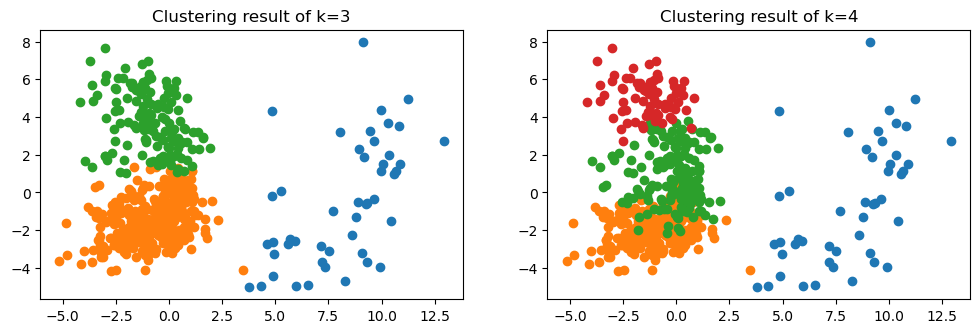

In [20]:
from sklearn.decomposition import PCA

#For visualization, project to 2 PCs

pca = PCA(n_components=2)
pca.fit(X)
X_proj = pca.transform(X)

fig = plt.figure(figsize=(12, 3.5))

closest_indices, centroids = kmeans(X, 3)
fig.add_subplot(1, 2, 1)
plt.scatter(X_proj[closest_indices==0, 0], X_proj[closest_indices==0, 1])
plt.scatter(X_proj[closest_indices==1, 0], X_proj[closest_indices==1, 1])
plt.scatter(X_proj[closest_indices==2, 0], X_proj[closest_indices==2, 1])
plt.title('Clustering result of k=3')

closest_indices, centroids = kmeans(X, 4)
fig.add_subplot(1, 2, 2)
plt.scatter(X_proj[closest_indices==0, 0], X_proj[closest_indices==0, 1])
plt.scatter(X_proj[closest_indices==1, 0], X_proj[closest_indices==1, 1])
plt.scatter(X_proj[closest_indices==2, 0], X_proj[closest_indices==2, 1])
plt.scatter(X_proj[closest_indices==3, 0], X_proj[closest_indices==3, 1])
plt.title('Clustering result of k=4')

plt.show()

## Expected Result

<img src = "A6image3.png">

***
 Let's compare with the ground truth, i.e., labeled data.

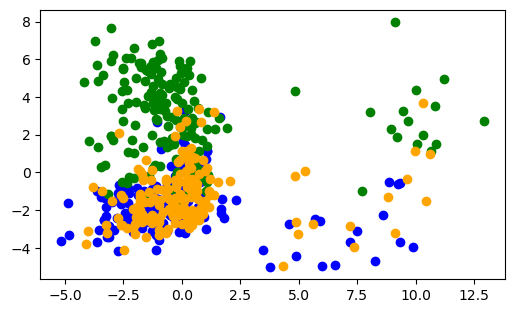

In [21]:
fig = plt.figure(figsize=(6, 3.5))

plt.scatter(X_proj[:163, 0], X_proj[:163, 1], c='blue')
plt.scatter(X_proj[163:327, 0], X_proj[163:327, 1], c='green')
plt.scatter(X_proj[327:491, 0], X_proj[327:491, 1], c='orange')

plt.show()

## Expected Result

<img src = "A6image4.png">

Roughly speaking, looks like k-means (k=3)distinguishes well between class 1 and class 2 as long as they are in the big cluster. Otherwise it doesn't do too well and doesn't deal well with outliers

### Directly using the KMeans function from sklearn (Ungraded)

Double check the results obtained earlier with the results here.

In [22]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming X is your data matrix of shape (m samples, n features)
# Specify the number of clusters (k)
k = 3

np.random.seed(1)
initial_centroids = X[np.random.choice(X.shape[0], k, replace=False),:]
    
# Create a KMeans instance
kmeans = KMeans(n_clusters=k, init=initial_centroids, n_init=1)

# Fit the KMeans model to your data
kmeans.fit(X)

# Obtain cluster labels for each data point
labels = kmeans.labels_

# Obtain cluster centers
centers = kmeans.cluster_centers_

print('closest_indices[:10]', labels[:10])
print('closest_indices[70:80]', labels[70:80])
print('closest_indices[140:150]', labels[140:150])
print('closest_indices[210:220]', labels[210:220])

closest_indices[:10] [1 1 0 0 1 1 1 1 1 0]
closest_indices[70:80] [1 1 1 1 1 1 1 1 1 1]
closest_indices[140:150] [1 1 1 1 1 1 1 1 1 0]
closest_indices[210:220] [2 1 1 1 2 2 2 2 2 2]


c:\Users\anama\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


## Expected Result

Ignore warning

<img src = "A6image5.png">


# Task 6 Compare Kmeans and DBScan for 2 moons dataset. 
Use functions from sklearn

# Two moons dataset

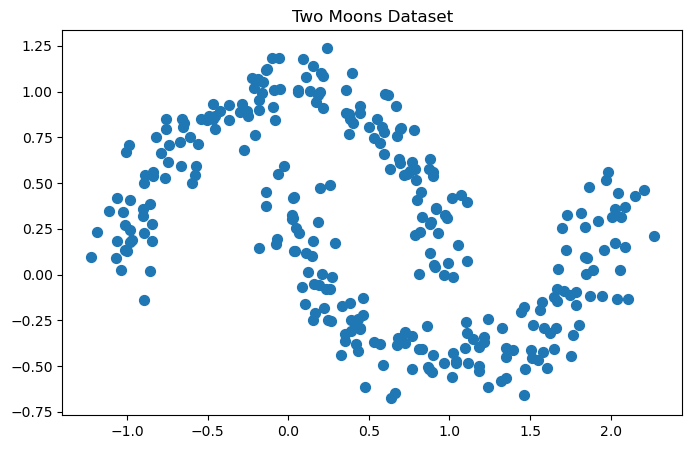

In [23]:
#Don't change code in this cell.
from sklearn.datasets import make_moons

# Generate two moon dataset
X, y = make_moons(n_samples=300, noise=0.1, random_state=42)

# Visualize the dataset
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.title('Two Moons Dataset')
plt.show()

# Expected Result

<img src = "A6image6.png">

# Task 6a Apply KMeans Clustering
**2 Points**


c:\Users\anama\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<Figure size 800x500 with 0 Axes>

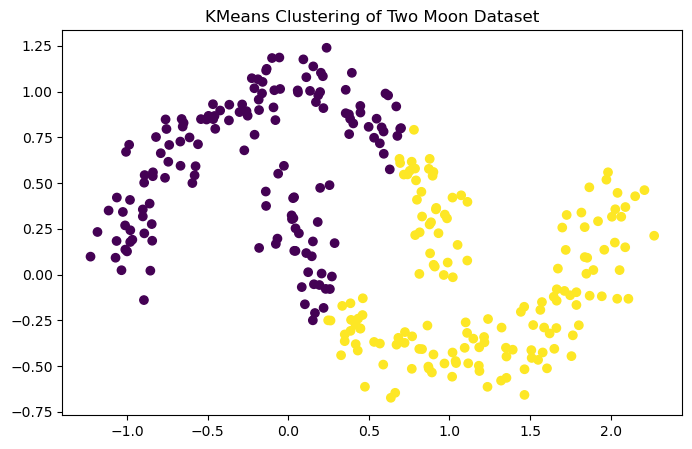

In [25]:
# Apply KMeans clustering, use random_state 42
from sklearn.cluster import KMeans
#Begin your code, return labels in y_kmeans

kmeans = KMeans(n_clusters=2, random_state=42)
y_kmeans = kmeans.fit_predict(X)

#End your code
# Visualize the results
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans)
plt.title('KMeans Clustering of Two Moon Dataset')
plt.show()

# Expected Results

<img src = "A6image7.png">

Ignore any warnings

# Observation
KMeans assumes clusters are spherical, so it fails to correctly separate the two moon-shaped clusters, leading to incorrect clustering.

## Task 6b: Apply DBSCAN with Different Epsilon Values
**2 Points**<br>
**Instructions:**

*  Use the following epsilon values: [0.1, 0.15, 0.2, 0.25, 0.3]
*   Run DBSCAN for each epsilon value and observe how the clustering results change.
*   Analyze how different epsilon values impact the formation of clusters and noise points.

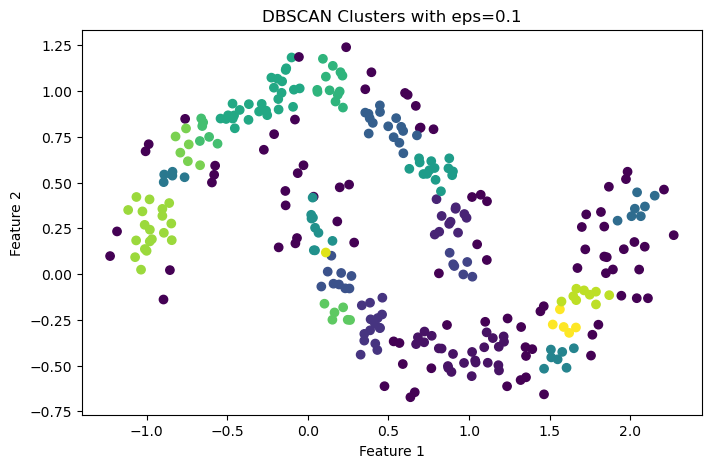

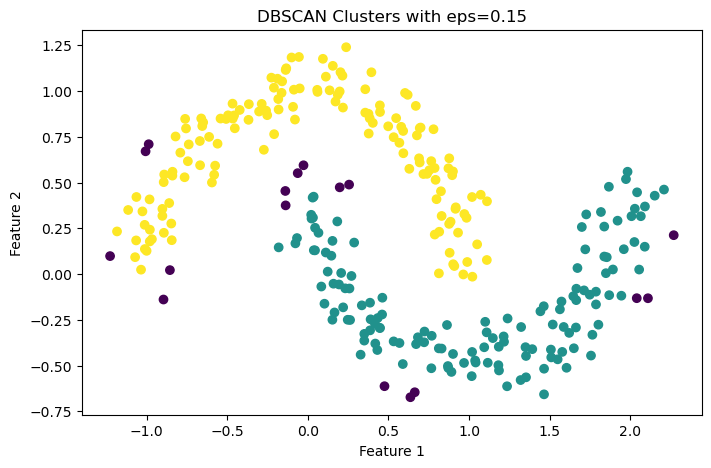

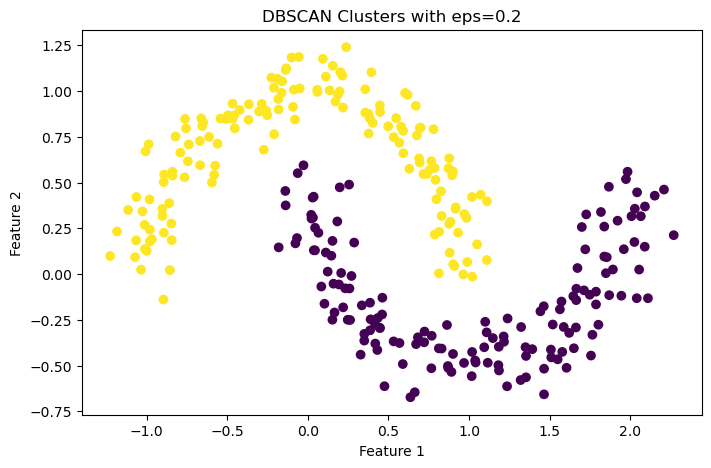

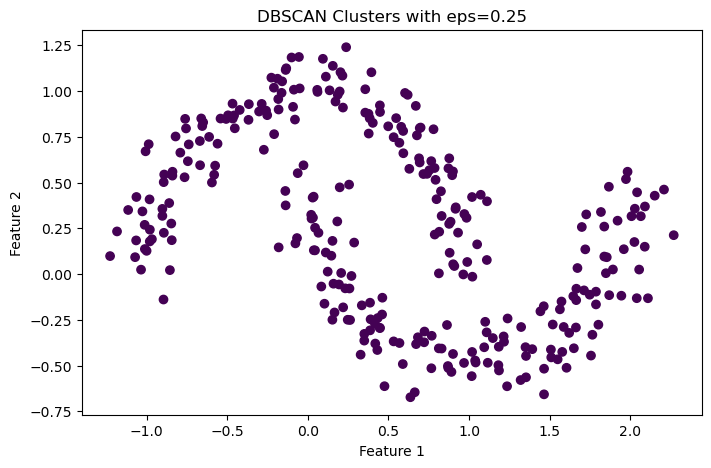

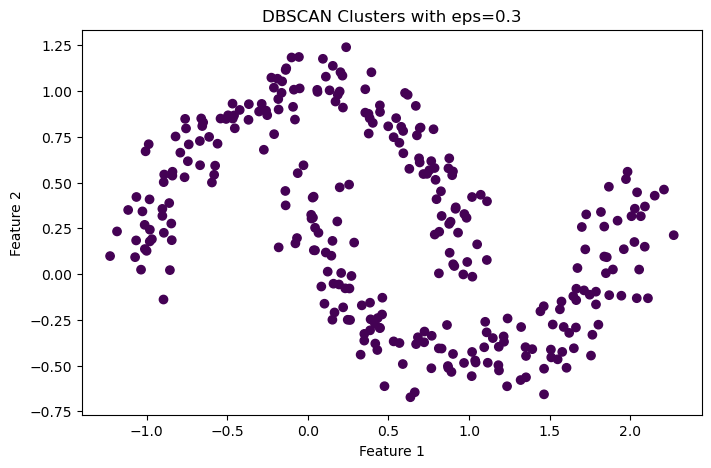

In [26]:
from sklearn.cluster import DBSCAN
# List of epsilon values to try
epsilon_values = [0.1, 0.15, 0.2, 0.25, 0.3]

# Loop over different epsilon values
for eps in epsilon_values:
    # Apply DBSCAN with current epsilon, return labels in clusters
    #Start your code#
    dbscan = DBSCAN(eps=eps, min_samples=5)
    clusters = dbscan.fit_predict(X)
    
    #End your code
    # Plot each clustering result
    plt.figure(figsize=(8, 5))
    plt.scatter(X[:, 0], X[:, 1], c=clusters)
    plt.title(f'DBSCAN Clusters with eps={eps}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Expected Result
<img src = "A6image8.png"><br>
<img src = "A6image9.png"><br>
<img src = "A6image10.png"><br>

# Observation
DBSCAN is a density-based clustering algorithm. Unlike KMeans, it does not assume clusters are spherical and can detect arbitrarily shaped clusters. By tuning the epsilon parameter, we can achieve better separation of the two moon-shaped clusters.